# Project 3 Workspace

## Imports

In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier


## Loading / Looking at Dataset

In [5]:
df = pd.read_csv('Terry_Stops.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54462 entries, 0 to 54461
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         54462 non-null  object
 1   Subject ID                54462 non-null  int64 
 2   GO / SC Num               54462 non-null  int64 
 3   Terry Stop ID             54462 non-null  int64 
 4   Stop Resolution           54462 non-null  object
 5   Weapon Type               54462 non-null  object
 6   Officer ID                54462 non-null  object
 7   Officer YOB               54462 non-null  int64 
 8   Officer Gender            54462 non-null  object
 9   Officer Race              54462 non-null  object
 10  Subject Perceived Race    54462 non-null  object
 11  Subject Perceived Gender  54462 non-null  object
 12  Reported Date             54462 non-null  object
 13  Reported Time             54462 non-null  object
 14  Initial Call Type     

In [7]:
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,26 - 35,-1,20170000475010,365576,Offense Report,None,7502,1981,M,White,...,22:06:00.0000000,"NARCOTICS WARRANT SERVICE - EXECUTED, SECURED",--NARCOTICS - NARCOTICS WARRANT SERVICE,"TELEPHONE OTHER, NOT 911",SOUTH PCT OPS - DAY ACT,N,Y,West,K,K3
1,36 - 45,-1,20160000300300,457869,Arrest,None,5727,1970,M,Asian,...,18:07:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--MISC MISD AND VIOLS - RECKLESS ENDANGERMENT,ONVIEW,WEST PCT OPS - MOUNTED PATROL,N,N,West,K,K2
2,26 - 35,-1,20150000004131,72536,Field Contact,None,7512,1970,M,White,...,21:57:00.0000000,-,-,-,SOUTH PCT 3RD W - ROBERT,N,N,South,S,S2
3,18 - 25,-1,20150000293740,75480,Offense Report,None,7403,1973,M,White,...,23:42:00.0000000,PROWLER - IP/JO,--PROWLER - TRESPASS,911,SOUTH PCT 3RD W - ROBERT,N,N,South,R,R1
4,46 - 55,-1,20170000004519,313328,Field Contact,None,5438,1958,M,White,...,17:39:00.0000000,-,-,-,SOUTHWEST PCT 2ND W - SOUTHWEST BEATS,N,N,-,-,-


In [8]:
df.shape

(54462, 23)

In [9]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

In [10]:
# Drop columns that will not be used 
df = df.drop(['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Sector', 'Beat', 'Officer Squad', 'Call Type'], axis=1)

In [11]:

# Create a new column called 'Arrest' and set it to 1 if the stop resolution was an arrest, and 0 otherwise
df['Arrest'] = df['Stop Resolution'].apply(lambda x: 1 if x == 'Arrest' else 0)


In [12]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Arrest Flag,Frisk Flag,Precinct,Arrest
0,26 - 35,Offense Report,None,7502,1981,M,White,Multi-Racial,Female,2017-12-27T00:00:00Z,22:06:00.0000000,"NARCOTICS WARRANT SERVICE - EXECUTED, SECURED",--NARCOTICS - NARCOTICS WARRANT SERVICE,N,Y,West,0
1,36 - 45,Arrest,None,5727,1970,M,Asian,Black or African American,Male,2016-08-19T00:00:00Z,18:07:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--MISC MISD AND VIOLS - RECKLESS ENDANGERMENT,N,N,West,1
2,26 - 35,Field Contact,None,7512,1970,M,White,White,Male,2015-08-12T00:00:00Z,21:57:00.0000000,-,-,N,N,South,0
3,18 - 25,Offense Report,None,7403,1973,M,White,Hispanic,Male,2015-08-22T00:00:00Z,23:42:00.0000000,PROWLER - IP/JO,--PROWLER - TRESPASS,N,N,South,0
4,46 - 55,Field Contact,None,5438,1958,M,White,Black or African American,Male,2017-09-23T00:00:00Z,17:39:00.0000000,-,-,N,N,-,0


In [17]:
df.columns

Index(['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Officer ID',
       'Officer YOB', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type', 'Arrest Flag',
       'Frisk Flag', 'Precinct', 'Arrest'],
      dtype='object')

In [18]:
print('Arrest Flag')
print(df["Arrest Flag"].value_counts(normalize=True))
print()
print('Frisk Flag')
print(df["Frisk Flag"].value_counts(normalize=True))

Arrest Flag
N    0.905494
Y    0.094506
Name: Arrest Flag, dtype: float64

Frisk Flag
N    0.758951
Y    0.232272
-    0.008777
Name: Frisk Flag, dtype: float64


In [13]:
df.drop(['Age Group'], axis=1)

KeyError: "['Age Group'] not found in axis"

# LogReg (First Simple Model)

In [347]:
# Select the predictor variables and the target variable
X = df[['Subject Age Group', 'Officer Race', 'Officer Gender', 'Subject Perceived Race', 'Subject Perceived Gender', 'Officer Age']]
y = df['Arrest']

# One-hot encode the categorical variables
X = pd.get_dummies(X, columns=['Subject Age Group', 'Officer Race', 'Officer Gender', 'Subject Perceived Race', 'Subject Perceived Gender'])

# Create a new target variable that indicates whether the stop resolution was an arrest

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LogisticRegression(max_iter=2000)

# Fit the model to the training data
model.fit(X_train, y_train)

# Score the model on the test data
score = model.score(X_test, y_test)
score


0.7560818874506564

# Dummy Classifier Model (Baseline Model)

In [346]:
# Prepare the data for modeling
X = df[['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
y = df['Arrest']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the classifier to the training data
dummy_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = dummy_clf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.7560818874506564


# Random Forest

In [415]:
from sklearn.preprocessing import LabelEncoder
# Prepare the data for modeling
X = df[['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
y = df['Arrest']

# Encode the categorical features as integers
X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rfc = RandomForestClassifier(max_depth=20, n_estimators=10,  criterion='gini', min_samples_split=5,
    min_samples_leaf=6, )

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc.predict(X_test)

scores = cross_val_score(rfc, X, y, cv=5)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)



Accuracy: 0.8263307984790874


# Gradient Booster

In [421]:
X = df[['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
y = df['Arrest']

# Create a gradient boosting classifier
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=5)

# Fit the classifier to the training data
gbc.fit(X_train, y_train)

# Predict on the test data
y_pred = gbc.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.8445817490494296


#  Decision Tree

In [387]:
# Prepare the data for modeling
X = df[['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
y = df['Arrest']

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
dt = DecisionTreeClassifier(max_depth=10, criterion='entropy', splitter='best', min_samples_split=3,
    min_samples_leaf=5)

# Fit the classifier to the training data
dt.fit(X_train, y_train)

# Predict on the test data
y_pred = dt.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.824199026898008


# ImPipeline

In [409]:


# Select the feature columns
X = df[['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
y = df['Arrest']


# Define the preprocessing steps for the categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessing steps for the numerical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, ['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct']),
    ('num', numeric_transformer, ['Officer Age'])
])

# Create the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Score the pipeline on the test data
score = pipeline.score(X_test, y_test)
print(f'Test score: {score:.2f}')


Test score: 0.76


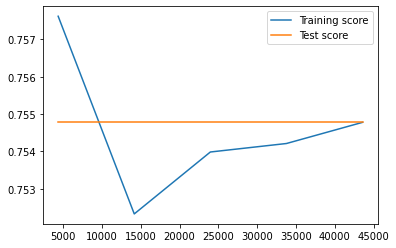

In [364]:
from sklearn.model_selection import learning_curve

# Calculate the training and test scores
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, cv=5)

# Plot the scores
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test score')
plt.legend(loc='best')
plt.show()


In [365]:
num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss',StandardScaler())
])

In [366]:
cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [367]:
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include=np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
],remainder='passthrough')

In [368]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [369]:
dummy_model = Pipeline([
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

In [370]:
dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy',X=X_train, y=y_train)
dummy_model_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.75446 ± 0.00008 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

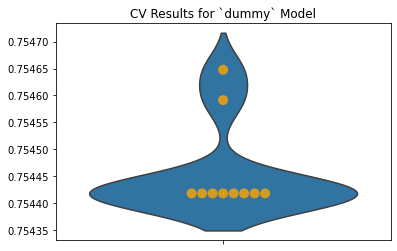

In [371]:
fig,ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

In [401]:
logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42))
])
# Use the class with out logreg pipe
fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)
fsm_model_pipe.print_cv_summary()

CV Results for `fsm` model:
            0.75315 ± 0.00303 accuracy
        


<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

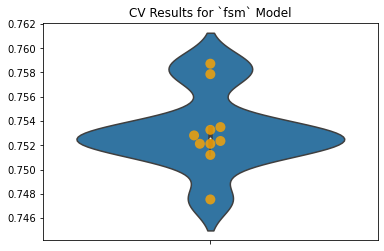

In [402]:
fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

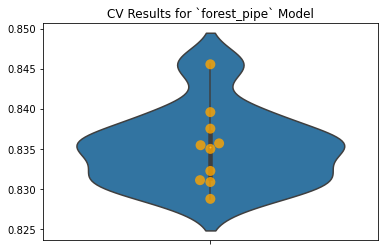

In [403]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [404]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.83516 ± 0.00467 accuracy
        


In [405]:
rfc_model_pipe.fit(X_train, y_train)
rfc_model_pipe.score(X_test, y_test)

0.8397135775268522

In [373]:
X = df[['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
X = pd.get_dummies(X, columns=['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct'], drop_first=True)

# Select the target variable
y = df['Arrest']

# Define the parameter grid
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [5, 10, 15, 20]}

# Create the model
model = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X, y)

# Print the best set of hyperparameters
print(grid_search.best_params_)

{'max_depth': 20, 'n_estimators': 10}


In [408]:
grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None ,5, 10, 15, 20],
    'min_samples_split': [3, 6, 9, 12],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
dt = DecisionTreeClassifier()
gs1 = GridSearchCV(estimator=dt, param_grid=grid).fit(X_train, y_train)

KeyboardInterrupt: 

In [406]:
gs1.best_estimator_

NameError: name 'gs1' is not defined

In [407]:
gs1.best_score_

NameError: name 'gs1' is not defined

# Visuals

In [21]:
df['Weapon Type'].value_counts()

None                                    32565
-                                       18540
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument        1014
Handgun                                   346
Blunt Object/Striking Implement           129
Firearm Other                             100
Firearm                                    70
Club, Blackjack, Brass Knuckles            49
Other Firearm                              45
Mace/Pepper Spray                          44
Firearm (unk type)                         15
Taser/Stun Gun                             13
None/Not Applicable                        11
Fire/Incendiary Device                     11
Rifle                                       9
Club                                        9
Shotgun                                     4
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Brass Knuckles                              1
Blackjack                         

In [22]:
import pandas as pd

# Create a dictionary of replacements
replacements = {
    'Lethal Cutting Instrument': 'Cutting Instrument',
    'Knife/Cutting/Stabbing Instrument': 'Cutting Instrument',
    'Blunt Object/Striking Implement': 'Blunt Object',
    'Firearm Other': 'Firearm',
    'Other Firearm': 'Firearm',
    'Mace/Pepper Spray': 'Pepper Spray',
    'Firearm (unk type)': 'Firearm',
    'Taser/Stun Gun': 'Stun Gun',
    'None/Not Applicable': 'Not Applicable',
    'Fire/Incendiary Device': 'Incendiary Device',
    'Personal Weapons (hands, feet, etc.)': 'Personal Weapons',
    'Automatic Handgun': 'Handgun',
    'Blackjack': 'Club',
    'Brass Knuckles': 'Club'
}

# Replace the values in the 'Weapon Type' column
df['Weapon Type'] = df['Weapon Type'].replace(replacements)


In [23]:
import datetime

# Get the current year
current_year = datetime.datetime.now().year
import datetime

# Get the current year
current_year = datetime.datetime.now().year

# Calculate the age
def calculate_age(year_of_birth):
    return current_year - year_of_birth
# Apply the function to the 'Year of Birth' column
df['Officer Age'] = df['Officer YOB'].apply(calculate_age)


In [24]:
df['Subject Age Group'].value_counts()

26 - 35         18207
36 - 45         11846
18 - 25         10641
46 - 55          6970
56 and Above     2835
1 - 17           2099
-                1864
Name: Subject Age Group, dtype: int64

In [25]:
# Group the data by 'officer age' and calculate the number of arrests for each group
arrests_by_age = df[df['Arrest Flag'] == 1].groupby('Officer Age')['Arrest Flag'].size()


In [26]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Arrest Flag,Frisk Flag,Precinct,Arrest,Officer Age
0,26 - 35,Offense Report,None,7502,1981,M,White,Multi-Racial,Female,2017-12-27T00:00:00Z,22:06:00.0000000,"NARCOTICS WARRANT SERVICE - EXECUTED, SECURED",--NARCOTICS - NARCOTICS WARRANT SERVICE,N,Y,West,0,42
1,36 - 45,Arrest,None,5727,1970,M,Asian,Black or African American,Male,2016-08-19T00:00:00Z,18:07:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--MISC MISD AND VIOLS - RECKLESS ENDANGERMENT,N,N,West,1,53
2,26 - 35,Field Contact,None,7512,1970,M,White,White,Male,2015-08-12T00:00:00Z,21:57:00.0000000,-,-,N,N,South,0,53
3,18 - 25,Offense Report,None,7403,1973,M,White,Hispanic,Male,2015-08-22T00:00:00Z,23:42:00.0000000,PROWLER - IP/JO,--PROWLER - TRESPASS,N,N,South,0,50
4,46 - 55,Field Contact,None,5438,1958,M,White,Black or African American,Male,2017-09-23T00:00:00Z,17:39:00.0000000,-,-,N,N,-,0,65


In [27]:
df['Weapon Type'].value_counts()

None                               32565
-                                  18540
Cutting Instrument                  2496
Handgun                              348
Firearm                              230
Blunt Object                         129
Club, Blackjack, Brass Knuckles       49
Pepper Spray                          44
Stun Gun                              13
Club                                  11
Not Applicable                        11
Incendiary Device                     11
Rifle                                  9
Shotgun                                4
Personal Weapons                       2
Name: Weapon Type, dtype: int64

In [28]:
replacements = {
    'Blunt Object/Striking Implement': 'Blunt / Striking Object', 
    'Club, Blackjack, Brass Knuckles': 'Blunt / Striking Object',
    'Club': 'Blunt / Striking Object',
    'Brass Knuckles': 'Blunt / Striking Object',
    'Blackjack': 'Blunt / Striking Object'
    
}

df['Weapon Type'] = df['Weapon Type'].replace(replacements)


In [29]:
replacements = {
    'Lethal Cutting Instrument': 'Cutting / Stabbing Instrument',
    'Knife/Cutting/Stabbing Instrument': 'Cutting / Stabbing Instrument'
}

df['Weapon Type'] = df['Weapon Type'].replace(replacements)

In [30]:
replacements = {
    'Handgun': 'Firearm',
    'Firearm Other ': 'Firearm',
    'Firearm': 'Firearm',
    'Other Firearm': 'Firearm',
    'Firearm(unk type)': 'Firearm',
    'Rifle': 'Firearm',
    'Shotgun': 'Firearm', 
    'Automatic Handgun': 'Firearm'
}

df['Weapon Type'] = df['Weapon Type'].replace(replacements)

In [31]:

# Create a dictionary of replacements for Cutting / Stabbing Instri
replacements = {
    'Lethal Cutting Instrument': 'Cutting / Stabbing Instrument',
    'Knife/Cutting/Stabbing Instrument': 'Cutting / Stabbing Instrument'
}

df['Weapon Type'] = df['Weapon Type'].replace(replacements)


In [32]:
replacements = {
    'None': 'None',
    '-': 'None',
    'None/Not applicable': 'None'
}

# Replace the values in the 'Weapon Types' column
df['Weapon Type'] = df['Weapon Type'].replace(replacements)

In [35]:
arrest_counts_weapons = df[df['Stop Resolution'] == 'Arrest']['Weapon Type'].value_counts()
arrest_percentages = (arrest_counts_weapons / arrest_counts_weapons.sum()) * 100

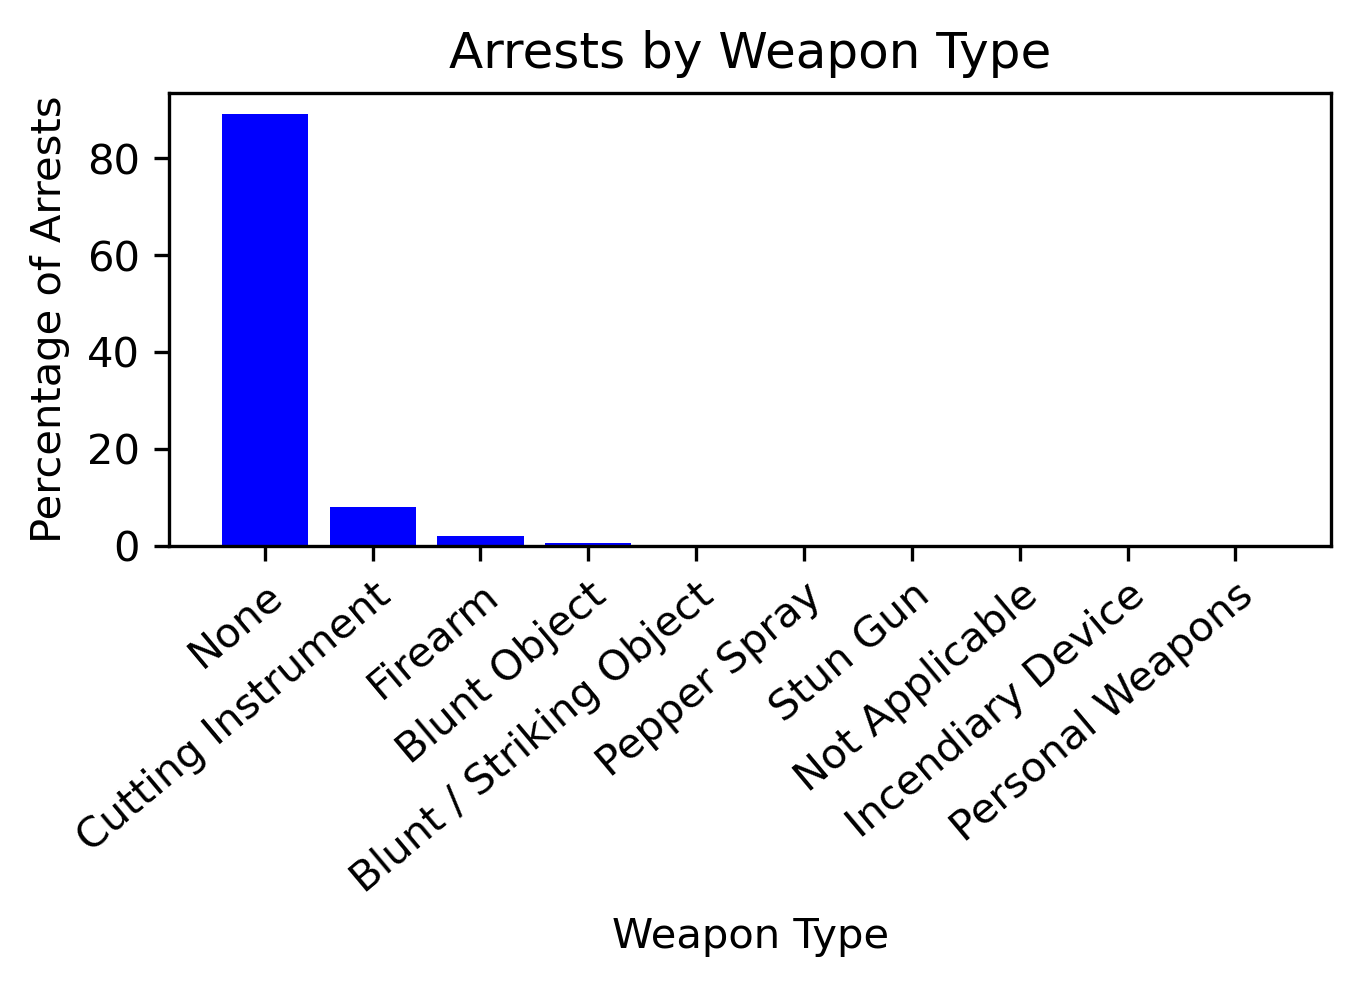

In [41]:
# Calculate the percentage of arrests for each weapon type
arrest_counts_weapons = df[df['Stop Resolution'] == 'Arrest']['Weapon Type'].value_counts()
arrest_percentages_weapons = (arrest_counts_weapons / arrest_counts_weapons.sum()) * 100

# Plot the arrests as a bar chart
plt.figure(figsize = (5,2), dpi = 300)
plt.bar(arrest_counts_weapons.index, arrest_percentages_weapons.values, color='blue')
plt.xlabel('Weapon Type')
plt.ylabel('Percentage of Arrests')
plt.title('Arrests by Weapon Type')
plt.xticks(rotation=40, rotation_mode='anchor', ha='right')

# Set the y-tick labels to the percentage values
plt.show()


In [5]:
resolution_counts = df['Stop Resolution'].value_counts()
resolution_percentages = (resolution_counts / resolution_counts.sum()) * 100

plt.figure(figsize = (10,3), dpi = 300)
plt.bar(resolution_percentages.index, resolution_percentages.values, color='blue')

plt.xlabel('Type')
plt.ylabel('Percentage of Stops')
plt.title('Outcomes')
plt.xticks(rotation=40, rotation_mode='anchor', ha='right')
plt.show()


NameError: name 'df' is not defined

In [1]:
arrest_counts_weapons = df[df['Stop Resolution'] == 'Arrest']['Weapon Type'].value_counts()
arrest_percentage_weapons = (arrest_counts_weapons / arrest_counts_weapons.sum()) * 100

# Plot the counts as a bar chart
plt.figure(figsize = (1,1), dpi = 300)
plt.bar(arrest_percentage_weapons.index, arrest_percentage_weapons.values, color='blue')
plt.xlabel('Weapon Type')
plt.ylabel('Percentage of Arrests')
plt.title('Arrests by Weapon Type')
plt.xticks(rotation=40, rotation_mode='anchor', ha='right')
plt.yticks(np.arange(0, 101, 10))
plt.show()


NameError: name 'df' is not defined

In [184]:
df['Arrest Flag'].value_counts()

N    49315
Y     5147
Name: Arrest Flag, dtype: int64

In [185]:
df['Stop Resolution'].value_counts()

Field Contact               23482
Offense Report              16706
Arrest                      13355
Referred for Prosecution      728
Citation / Infraction         191
Name: Stop Resolution, dtype: int64

In [213]:
bins = [20, 30, 40, 50, 60, 70]

# Bin the ages and create a new column with the bin labels
df['Officer Age Group'] = pd.cut(df['Officer Age'], bins, labels=['20-30', '30-40', '40-50', '50-60', '60-70'])


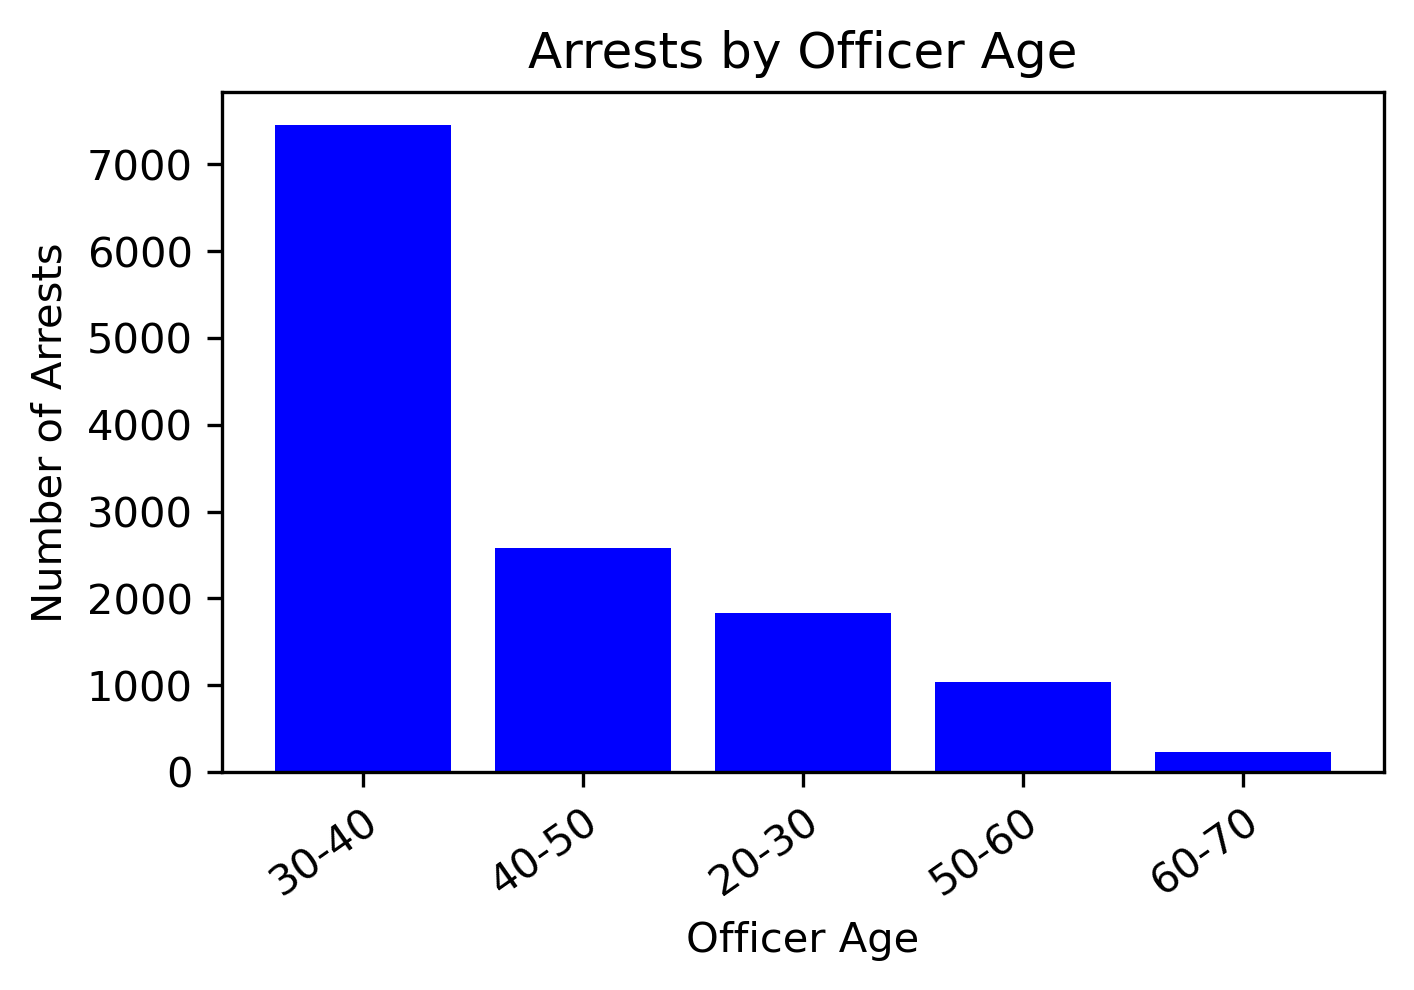

In [433]:
import matplotlib.pyplot as plt

# Count the number of arrests for each age group
arrest_counts_officer = df[df['Stop Resolution'] == 'Arrest']['Officer Age Group'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_counts_officer.index, arrest_counts_officer.values, color='blue')
plt.xlabel('Officer Age')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Officer Age')
plt.xticks(rotation=35, rotation_mode='anchor', ha='right')

plt.show()


In [413]:
df['Subject Age Group'].value_counts()

26 - 35         18207
36 - 45         11846
18 - 25         10641
46 - 55          6970
56 and Above     2835
1 - 17           2099
Name: Subject Age Group, dtype: int64

In [412]:
df.drop(df[df['Subject Age Group'] == '-'].index, inplace=True)

In [431]:
arrest_counts_officer.sum()

13121

In [430]:
arrest_counts_subject.sum()

13142

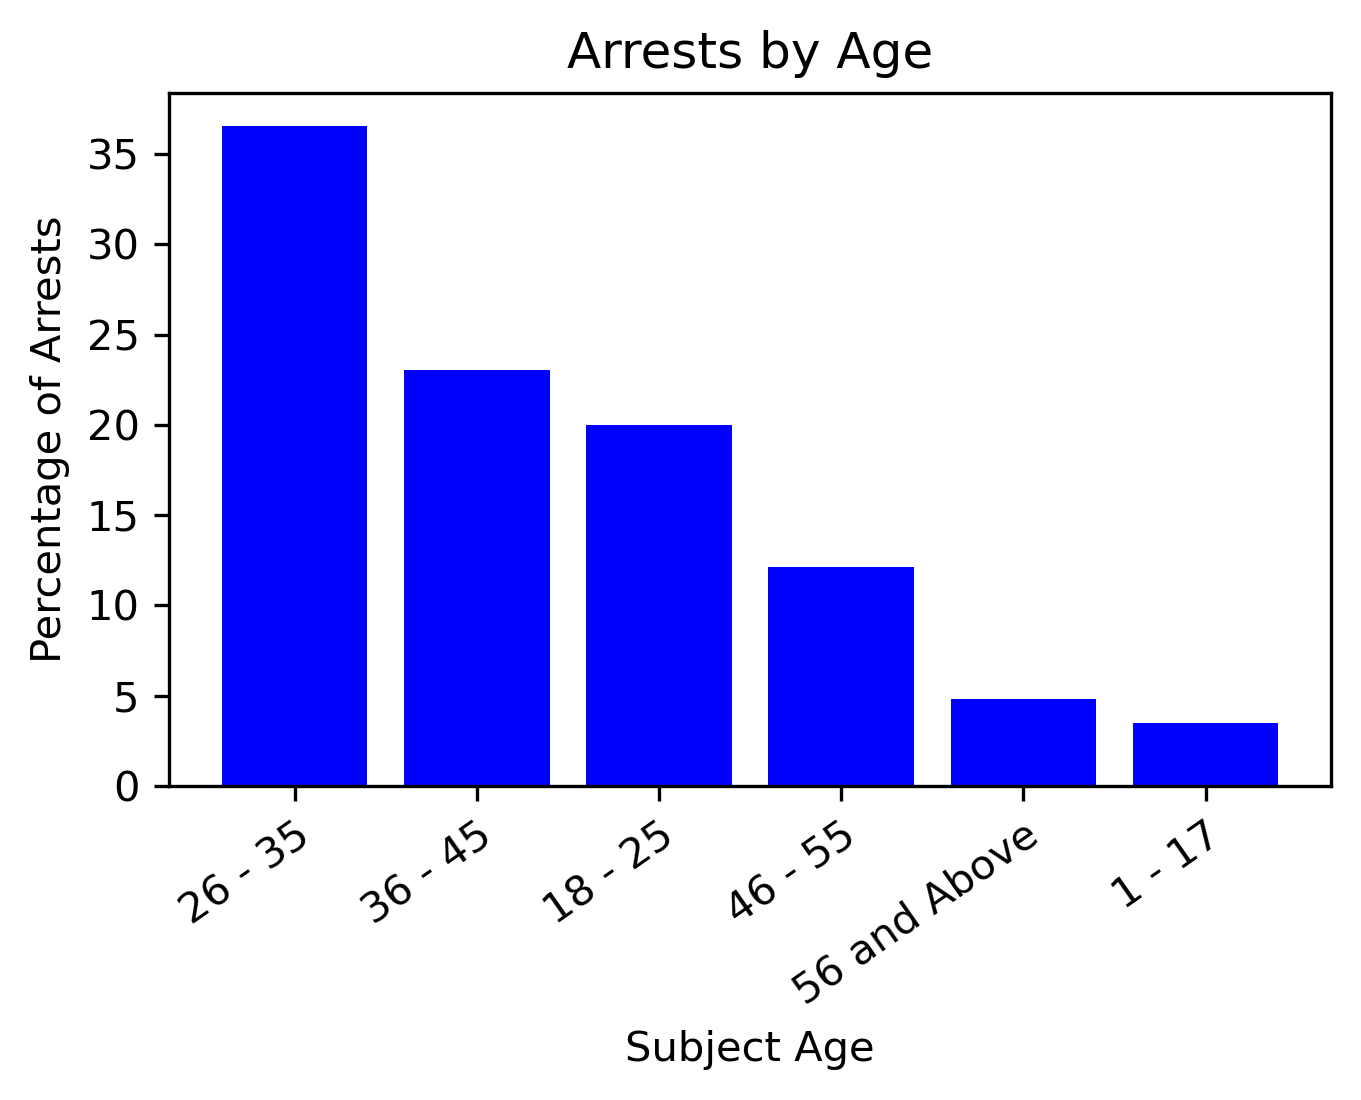

In [672]:
arrest_counts_subject_age = df[df['Stop Resolution'] == 'Arrest']['Subject Age Group'].value_counts()
arrest_percentage_age = (arrest_counts_subject_age / arrest_counts_subject_age.sum()) * 100
# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_percentage_age.index, arrest_percentage_age.values, color='blue')
plt.xlabel('Subject Age')
plt.ylabel('Percentage of Arrests')
plt.title('Arrests by Age')
plt.xticks(rotation=35, rotation_mode='anchor', ha='right')
plt.show()

In [253]:
df['Reported Date'].min()

'2015-03-15T00:00:00Z'

In [258]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,...,Initial Call Type,Final Call Type,Arrest Flag,Frisk Flag,Precinct,Officer Age,Age Group,Officer Age Group,Arrest,Reported Date Time
0,26 - 35,Offense Report,None,7502,1981,M,White,Multi-Racial,Female,2017-12-27T00:00:00Z,...,"NARCOTICS WARRANT SERVICE - EXECUTED, SECURED",--NARCOTICS - NARCOTICS WARRANT SERVICE,N,Y,West,42,40-50,40-50,0,2017-12-27 22:06:00+00:00
1,36 - 45,Arrest,None,5727,1970,M,Asian,Black or African American,Male,2016-08-19T00:00:00Z,...,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--MISC MISD AND VIOLS - RECKLESS ENDANGERMENT,N,N,West,53,50-60,50-60,1,2016-08-19 18:07:00+00:00
2,26 - 35,Field Contact,None,7512,1970,M,White,White,Male,2015-08-12T00:00:00Z,...,-,-,N,N,South,53,50-60,50-60,0,2015-08-12 21:57:00+00:00
3,18 - 25,Offense Report,None,7403,1973,M,White,Hispanic,Male,2015-08-22T00:00:00Z,...,PROWLER - IP/JO,--PROWLER - TRESPASS,N,N,South,50,40-50,40-50,0,2015-08-22 23:42:00+00:00
4,46 - 55,Field Contact,None,5438,1958,M,White,Black or African American,Male,2017-09-23T00:00:00Z,...,-,-,N,N,-,65,60-70,60-70,0,2017-09-23 17:39:00+00:00


In [256]:
df['Reported Date Time'] = df['Reported Date'] + ' ' + df['Reported Time']

# Convert the 'Reported Date Time' column to datetime
df['Reported Date Time'] = pd.to_datetime(df['Reported Date Time'])

In [497]:
# Group the data by year and calculate the number of arrests for each year
arrests_by_year = df[df['Stop Resolution'] == 'Arrest'].groupby(df['Reported Date Time'].dt.year)['Stop Resolution'].size()


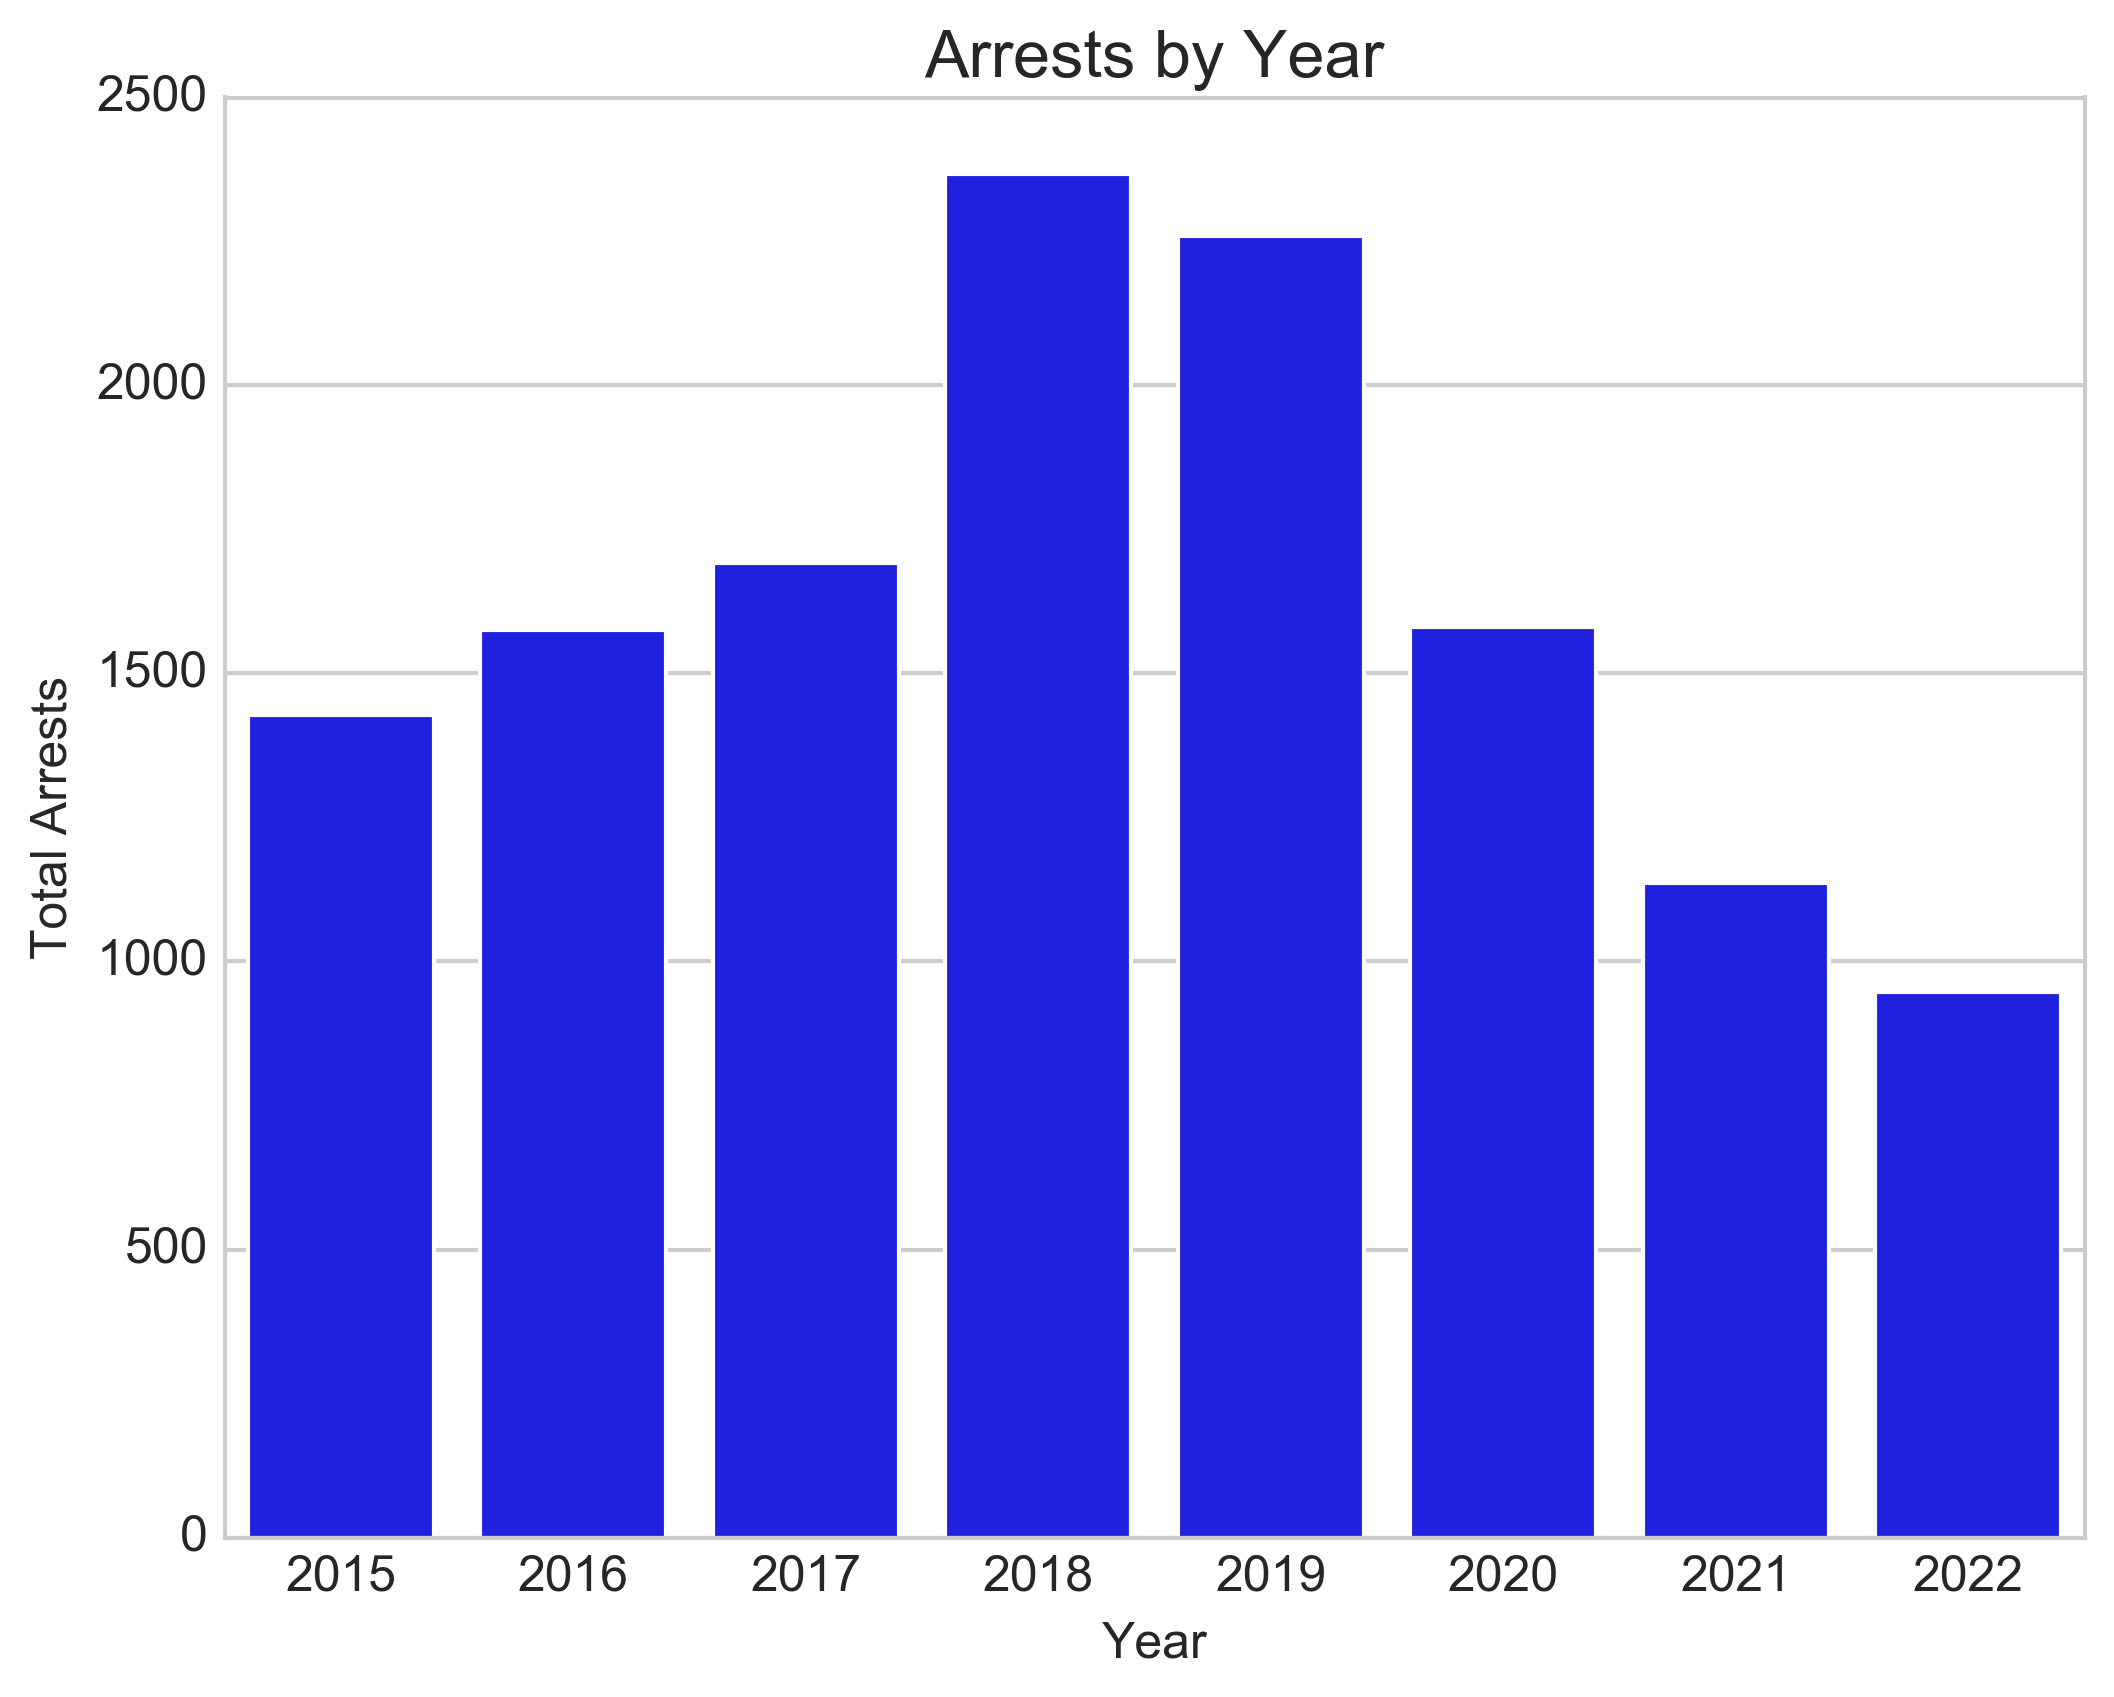

In [615]:
fig, ax = plt.subplots()
sns.barplot(x=arrests_by_year.index, y=arrests_by_year.values, color='blue', data=df).figure.set_dpi(300)
ax.set_xlabel('Year')
ax.set_ylabel('Total Arrests')
ax.set_title('Arrests by Year')
sns.set_style('ticks')

In [458]:
df['Subject Perceived Race'].value_counts()

White                                        26162
Black or African American                    15660
Unknown                                       3281
Asian                                         1783
Hispanic                                      1658
American Indian or Alaska Native              1496
Multi-Racial                                   801
Other                                          150
Native Hawaiian or Other Pacific Islander       99
Name: Subject Perceived Race, dtype: int64

In [457]:
df.drop(df[df['Subject Perceived Race'] == '-'].index, inplace=True)

In [665]:
# Create an empty list for the bins
bins = []

# Iterate through each value in the 'Subject Perceived Race' column
for value in df['Subject Perceived Race']:
    # If the value is 'White' or 'Unknown', append the value to the bins list
    if value == 'White' or value == 'Unknown':
        bins.append(value)
    # If the value is not 'White' or 'Unknown', append 'POC' to the bins list
    else:
        bins.append('POC')

# Add the bins list to the DataFrame as a new column
df['Subject Race Bins'] = bins


In [666]:
df['Subject Race Bins'].value_counts()

White      26136
POC        21624
Unknown     3262
Name: Subject Race Bins, dtype: int64

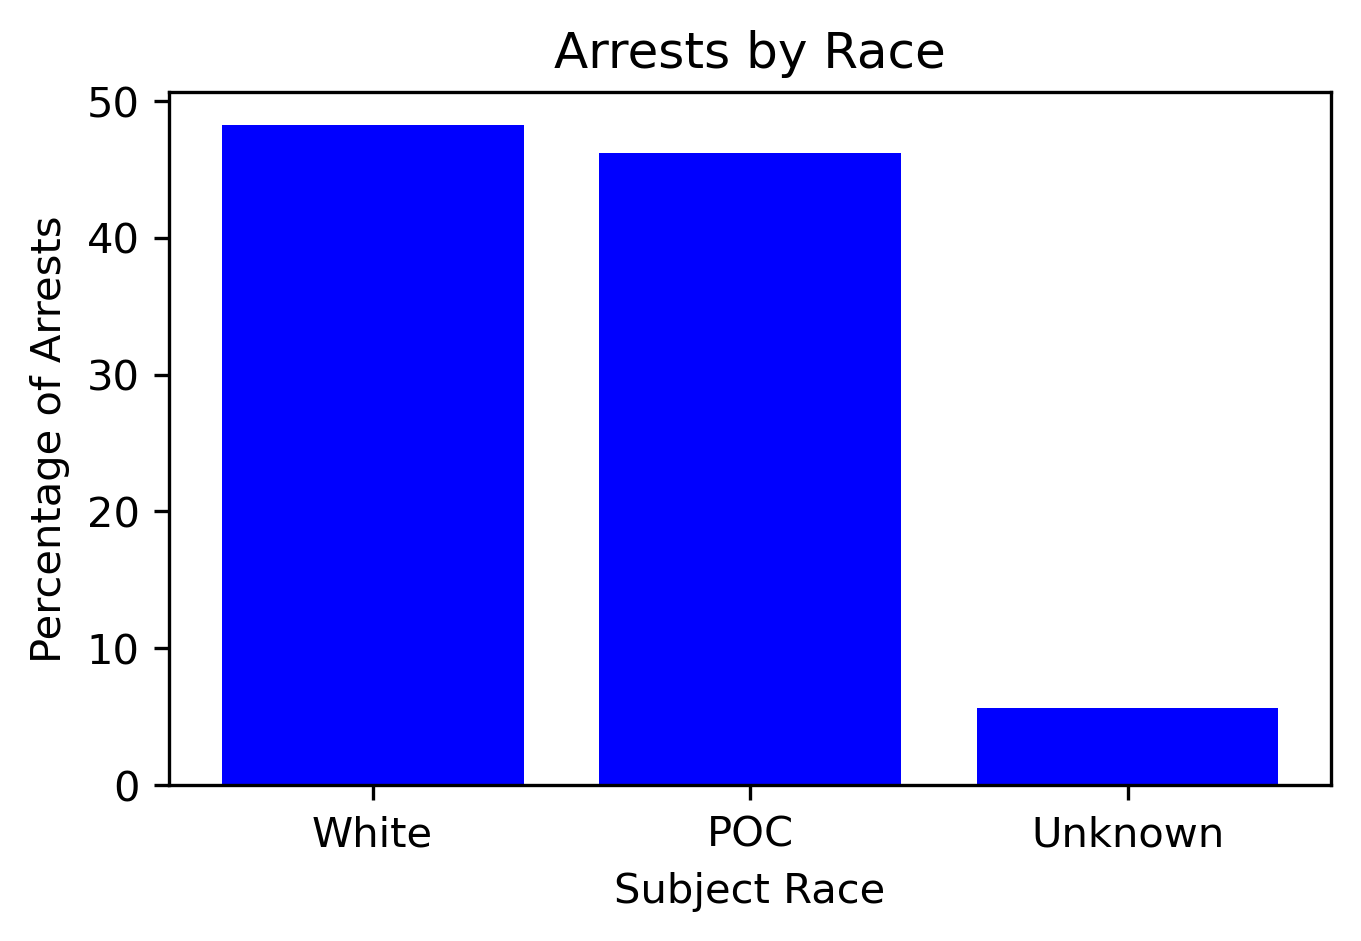

In [673]:
arrest_counts_subject_race = df[df['Stop Resolution'] == 'Arrest']['Subject Race Bins'].value_counts()
arrest_percentage_SR = (arrest_counts_subject_race / arrest_counts_subject_race.sum()) * 100

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_percentage_SR.index, arrest_percentage_SR.values, color='blue')
plt.xlabel('Subject Race')
plt.ylabel('Percentage of Arrests')
plt.title('Arrests by Race')
plt.show()

In [438]:
df.drop(df[df['Officer Race'] == 'Unknown'].index, inplace=True)

In [439]:
df['Officer Race'].value_counts()

White                            38612
Two or More Races                 3328
Hispanic or Latino                3205
Asian                             2325
Not Specified                     2258
Black or African American         1998
Nat Hawaiian/Oth Pac Islander      461
American Indian/Alaska Native      324
Name: Officer Race, dtype: int64

In [650]:
def bin_officer_race(row):
    if row['Officer Race'] == 'White':
        return 'White'
    else:
        return 'POC'

df['Officer Race Binned'] = df.apply(bin_officer_race, axis=1)


In [651]:
df['Officer Race Binned'].value_counts()

White    37513
POC      13509
Name: Officer Race Binned, dtype: int64

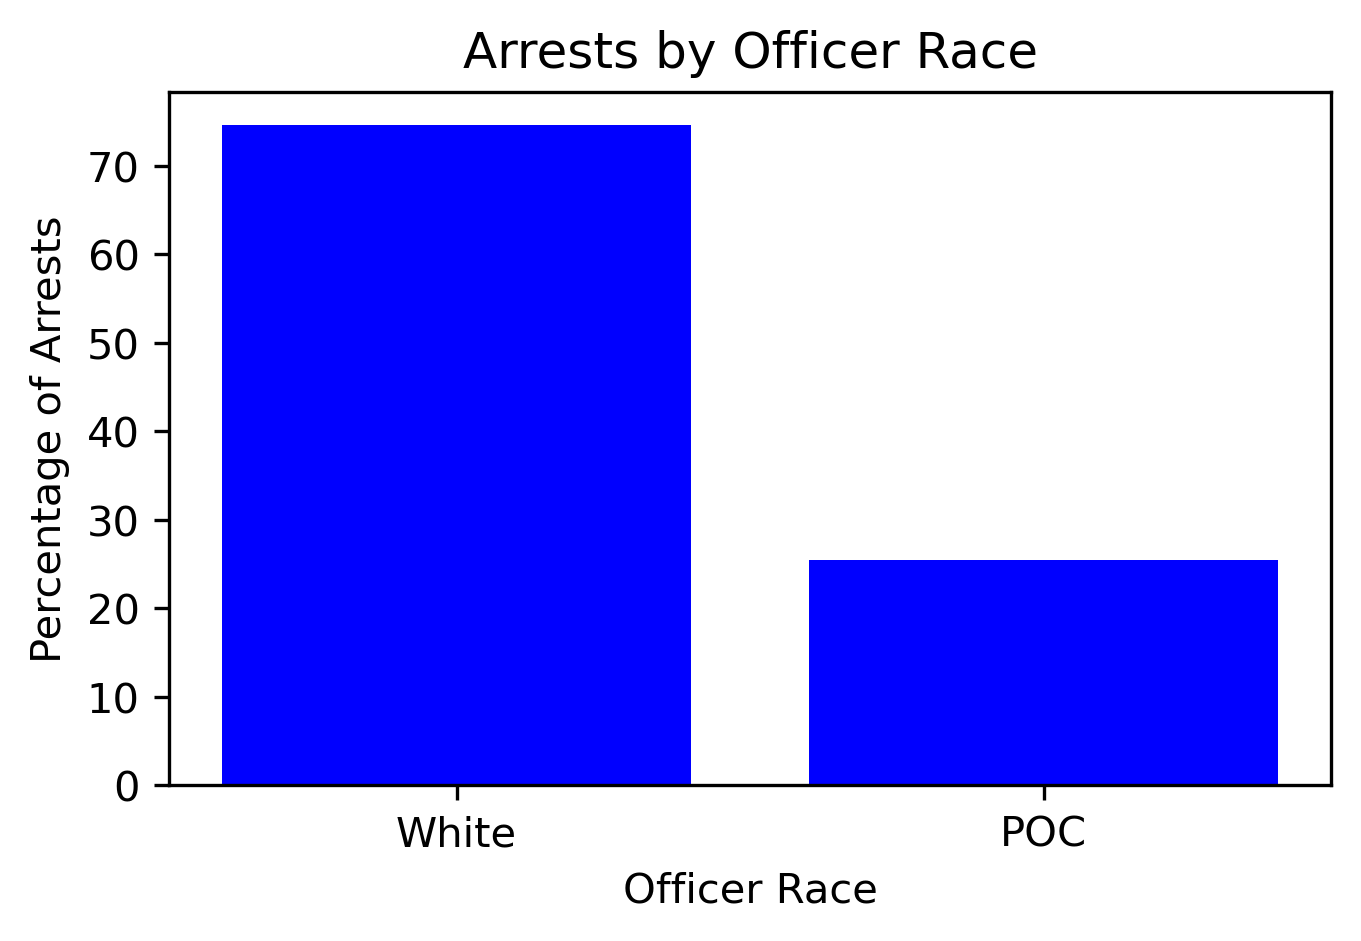

In [654]:
arrest_counts_OR = df[df['Stop Resolution'] == 'Arrest']['Officer Race Binned'].value_counts()
arrest_counts_OR = (arrest_counts_OR / arrest_counts_OR.sum()) * 100

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_counts_OR.index, arrest_counts_OR.values, color='blue')
plt.xlabel('Officer Race')
plt.ylabel('Percentage of Arrests')
plt.title('Arrests by Officer Race')
plt.show()

In [481]:
df['Precinct'].value_counts()

West         13473
North        11172
Unknown       9876
East          6618
South         5963
Southwest     3920
Name: Precinct, dtype: int64

In [480]:
df.drop(df[df['Precinct'] == 'FK ERROR'].index, inplace=True)

In [478]:
df.drop(df[df['Precinct'] == 'OOJ'].index, inplace=True)

In [475]:
replacements = {
    '-': 'Unknown',
    'Unknown ': 'Unknown '
}

df['Precinct'] = df['Precinct'].replace(replacements)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

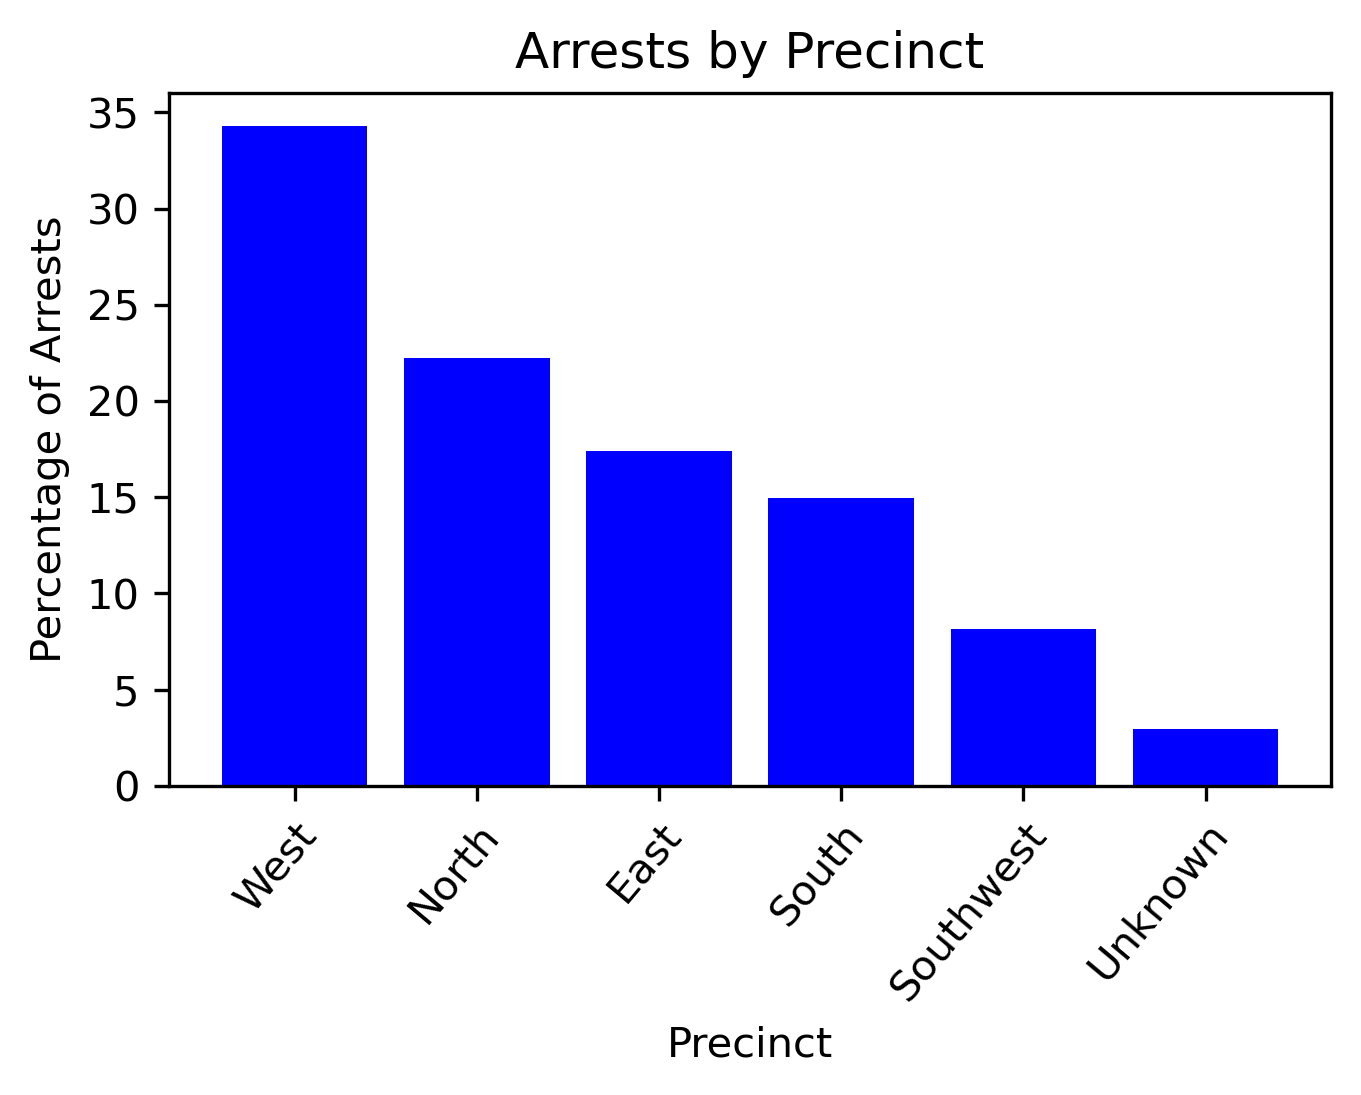

In [635]:
# Group the data by precinct and count the number of arrests for each precinct
arrest_counts_precinct = df[df['Stop Resolution'] == 'Arrest']['Precinct'].value_counts()
arrest_percentage_precinct = (arrest_counts_precinct / arrest_counts_precinct.sum()) * 100

plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_percentage_precinct.index, arrest_percentage_precinct.values, color='blue')
plt.xlabel('Precinct')
plt.ylabel('Percentage of Arrests')
plt.title('Arrests by Precinct')
plt.xticks(rotation=50, rotation_mode='anchor', ha='right')




In [677]:
df['Stop Resolution'].value_counts().sum()

51022

In [ ]:
arr

In [682]:
arrest_counts_precinct.sum()

12985

In [686]:
df['Weapon Type'].value_counts()

None                                    47836
Cutting / Stabbing Instrument            2391
Firearm                                   551
Blunt / Striking Object                   178
Mace/Pepper Spray                          41
Taser/Stun Gun                             13
Fire/Incendiary Device                     10
Personal Weapons (hands, feet, etc.)        2
Name: Weapon Type, dtype: int64

In [690]:
df['Officer Race'].value_counts()

White                            37513
Two or More Races                 3233
Hispanic or Latino                3103
Asian                             2272
Not Specified                     2205
Black or African American         1929
Nat Hawaiian/Oth Pac Islander      453
American Indian/Alaska Native      314
Name: Officer Race, dtype: int64

In [691]:
df['Officer Race Binned'].value_counts()

White    37513
POC      13509
Name: Officer Race Binned, dtype: int64

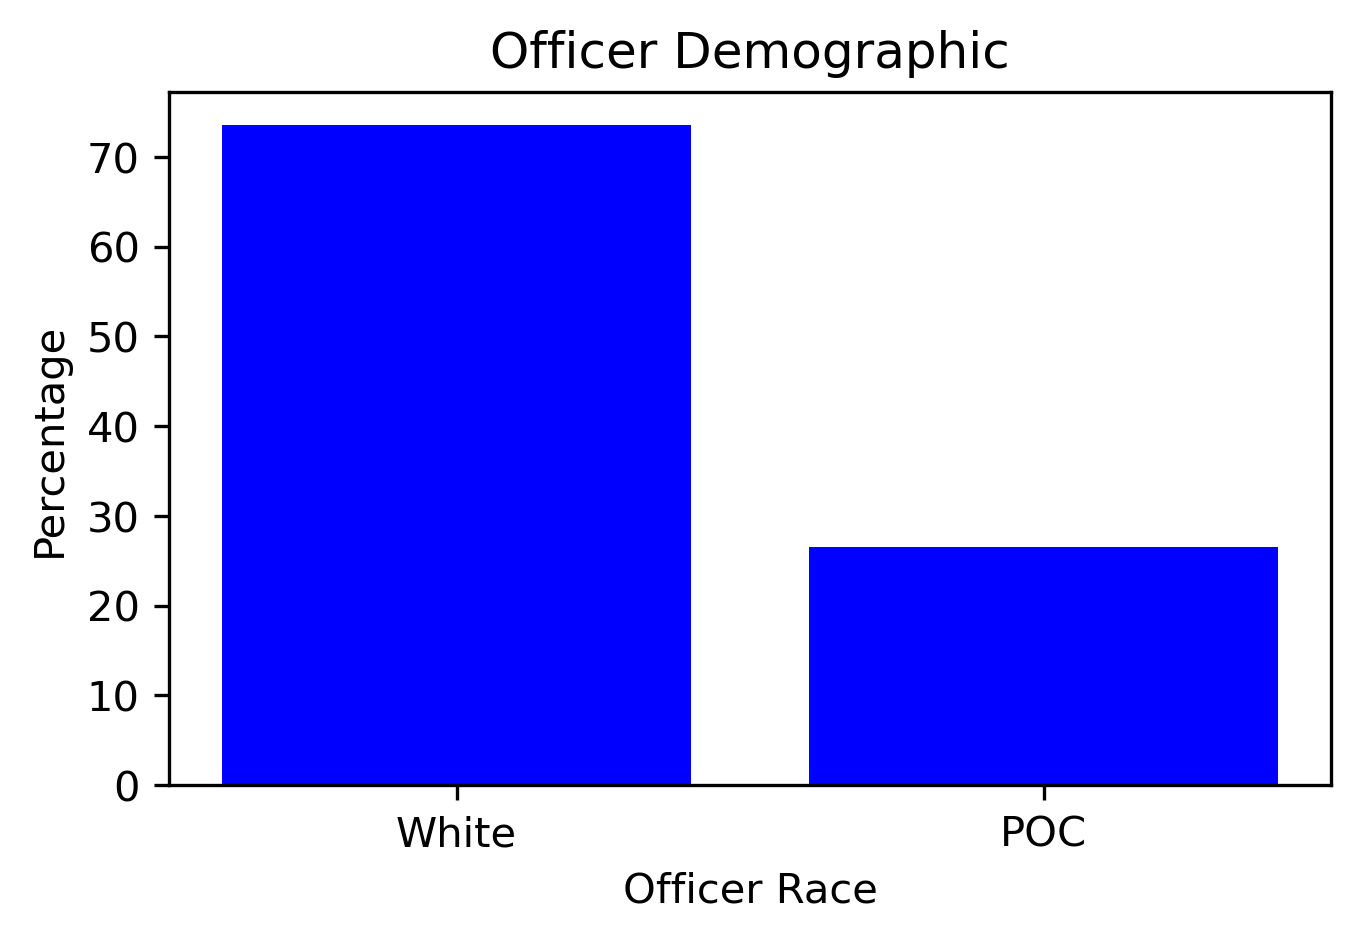

In [694]:
ORB = df['Officer Race Binned'].value_counts()
ORB_percentage = (ORB / ORB.sum()) * 100

plt.figure(figsize = (5,3), dpi = 300)
plt.bar(ORB_percentage.index, ORB_percentage, color='blue')
plt.xlabel('Officer Race')
plt.ylabel('Percentage')
plt.title('Officer Demographic')
plt.show()

In [695]:
df['Reported Time'].value_counts()

03:09:00.0000000    50
02:56:00.0000000    49
19:01:00.0000000    48
03:13:00.0000000    48
19:18:00.0000000    47
                    ..
14:41:25.0000000     1
05:38:26.0000000     1
05:50:42.0000000     1
00:24:19.0000000     1
17:46:01.0000000     1
Name: Reported Time, Length: 16986, dtype: int64

In [701]:
# Convert the Reported Time column to datetime data type
df['Reported Time'] = pd.to_datetime(df['Reported Time'])

# Create a function to determine the time of day based on the hour of the datetime value
def get_time_of_day(time):
    if time.hour >= 6 and time.hour < 12:
        return 'Morning'
    elif time.hour >= 12 and time.hour < 18:
        return 'Afternoon'
    elif time.hour >= 18 and time.hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the Reported Time column and store the result in a new column called Time of Day
df['Time of Day'] = df['Reported Time'].apply(get_time_of_day)


In [702]:
df['Time of Day'].value_counts()

Evening      14071
Night        13925
Afternoon    13140
Morning       9886
Name: Time of Day, dtype: int64

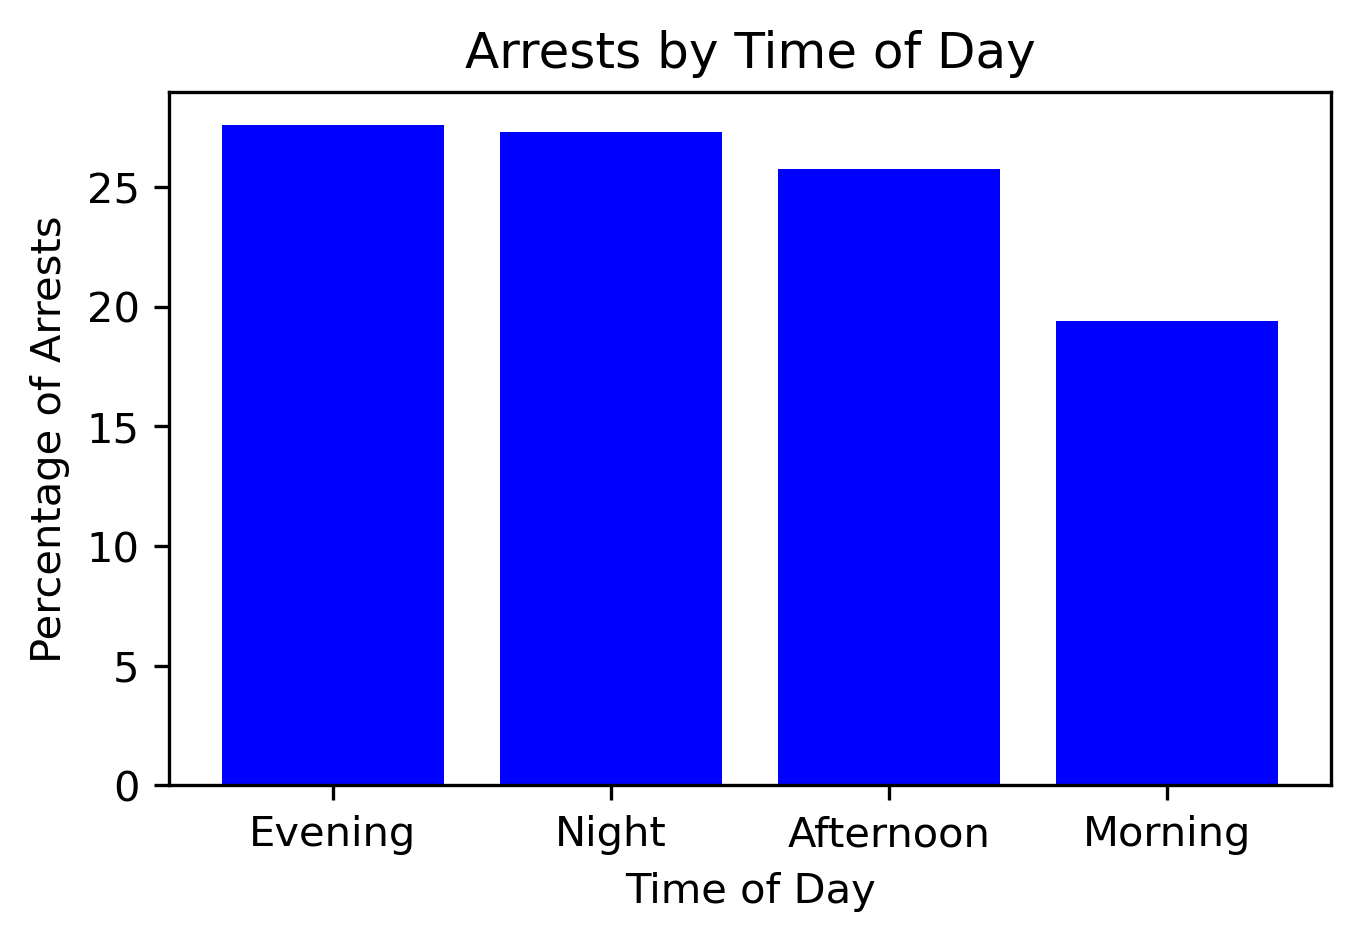

In [706]:
arrest_TOD = df['Time of Day'].value_counts()
arrest_TOD_percent = (arrest_TOD / arrest_TOD.sum()) * 100

plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_TOD_percent.index, arrest_TOD_percent, color='blue')
plt.xlabel('Time of Day')
plt.ylabel('Percentage of Arrests')
plt.title('Arrests by Time of Day')
plt.show()

In [707]:

# Create a new DataFrame with the columns 'Weapon Type' and 'Stop Resolution'
df_weapons = df[['Weapon Type', 'Stop Resolution']]

# Group the data by 'Weapon Type' and 'Stop Resolution' and count the number of arrests for each combination
arrest_counts_weapons = df_weapons.groupby(['Weapon Type', 'Stop Resolution']).size().reset_index(name='count')

# Print the resulting DataFrame
print(arrest_counts_weapons)


                             Weapon Type           Stop Resolution  count
0                Blunt / Striking Object                    Arrest     80
1                Blunt / Striking Object     Citation / Infraction      1
2                Blunt / Striking Object             Field Contact     52
3                Blunt / Striking Object            Offense Report     44
4                Blunt / Striking Object  Referred for Prosecution      1
5          Cutting / Stabbing Instrument                    Arrest   1043
6          Cutting / Stabbing Instrument     Citation / Infraction      4
7          Cutting / Stabbing Instrument             Field Contact    647
8          Cutting / Stabbing Instrument            Offense Report    648
9          Cutting / Stabbing Instrument  Referred for Prosecution     49
10                Fire/Incendiary Device                    Arrest      3
11                Fire/Incendiary Device             Field Contact      5
12                Fire/Incendiary Devi

In [708]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,...,Precinct,Officer Age,Age Group,Officer Age Group,Arrest,Reported Date Time,Officer Race Binned,Race Bins,Subject Race Bins,Time of Day
0,26 - 35,Offense Report,None,7502,1981,M,White,Multi-Racial,Female,2017-12-27T00:00:00Z,...,West,42,40-50,40-50,0,2017-12-27 22:06:00+00:00,White,POC,POC,Evening
1,36 - 45,Arrest,None,5727,1970,M,Asian,Black or African American,Male,2016-08-19T00:00:00Z,...,West,53,50-60,50-60,1,2016-08-19 18:07:00+00:00,POC,POC,POC,Evening
2,26 - 35,Field Contact,None,7512,1970,M,White,White,Male,2015-08-12T00:00:00Z,...,South,53,50-60,50-60,0,2015-08-12 21:57:00+00:00,White,White,White,Evening
3,18 - 25,Offense Report,None,7403,1973,M,White,Hispanic,Male,2015-08-22T00:00:00Z,...,South,50,40-50,40-50,0,2015-08-22 23:42:00+00:00,White,POC,POC,Evening
4,46 - 55,Field Contact,None,5438,1958,M,White,Black or African American,Male,2017-09-23T00:00:00Z,...,Unknown,65,60-70,60-70,0,2017-09-23 17:39:00+00:00,White,POC,POC,Afternoon


In [25]:
num_pipe = Pipeline([('ss', StandardScaler())])

cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

target_pipe = Pipeline([('le', LabelEncoder())])

In [26]:
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include = np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include = object)),
    ('target_trans', target_pipe, selector(dtype_include =bool))
],remainder='passthrough')

In [27]:
X = df.drop('Arrest', axis = 1)
y = df.Arrest
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

CV Results for `dummy` model:
            0.75486 ± 0.00010 accuracy
        


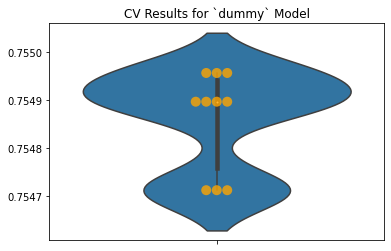

In [29]:
dummy_model = Pipeline([
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy',X=X_train, y=y_train)

# Visualizing results with violin and swarm plot

fig,ax = plt.subplots()
dummy_model_pipe.plot_cv(ax=ax)

dummy_model_pipe.print_cv_summary()

In [30]:
logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42))
])

fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)

# Visualizing results with violin and swarm plot
fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

fsm_model_pipe.print_cv_summary()

KeyboardInterrupt: 